In [445]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM # type: ignore
from tensorflow.keras import layers # type: ignore
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.losses import Huber # type: ignore

In [446]:
directories = ['../myhadoop/BTC-EUR_2020/*.csv', '../myhadoop/BTC-EUR_2021/*.csv', 
               '../myhadoop/BTC-EUR_2022/*.csv', '../myhadoop/BTC-EUR_2023/*.csv', 
               '../myhadoop/BTC-EUR_2024/*.csv']

dfs = [pd.concat((pd.read_csv(f) for f in glob.glob(directory)), ignore_index=True) for directory in directories]

data = pd.concat(dfs, ignore_index=True)

In [447]:
data['Date'] = pd.to_datetime(data['Open Time']).dt.date
data = data.loc[:,['Date','Open','High','Low','Close','Volume']]
data = data.set_index('Date')
data.index = pd.to_datetime(data.index,unit='ns')

In [448]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-03,6244.33,6608.59,6244.33,6568.73,3.558980
2020-01-04,6558.96,6690.00,6520.12,6568.18,1.829645
2020-01-05,6590.90,6699.28,6568.18,6589.00,3.365345
2020-01-06,6568.18,6950.00,6500.00,6914.15,10.250183
2020-01-07,6942.65,7352.71,6900.00,7315.60,29.517401
...,...,...,...,...,...
2024-10-06,56565.97,57382.39,56335.45,57257.50,78.981340
2024-10-07,57264.13,58746.44,56640.00,56727.15,187.162650
2024-10-08,56721.11,57593.21,56422.47,56653.42,143.294700


In [449]:
data = data[data['Volume'] > 0]
data = data.dropna()
data = data[np.isfinite(data['Close'])]
aim = 'Close'

In [450]:
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('BITCOIN', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

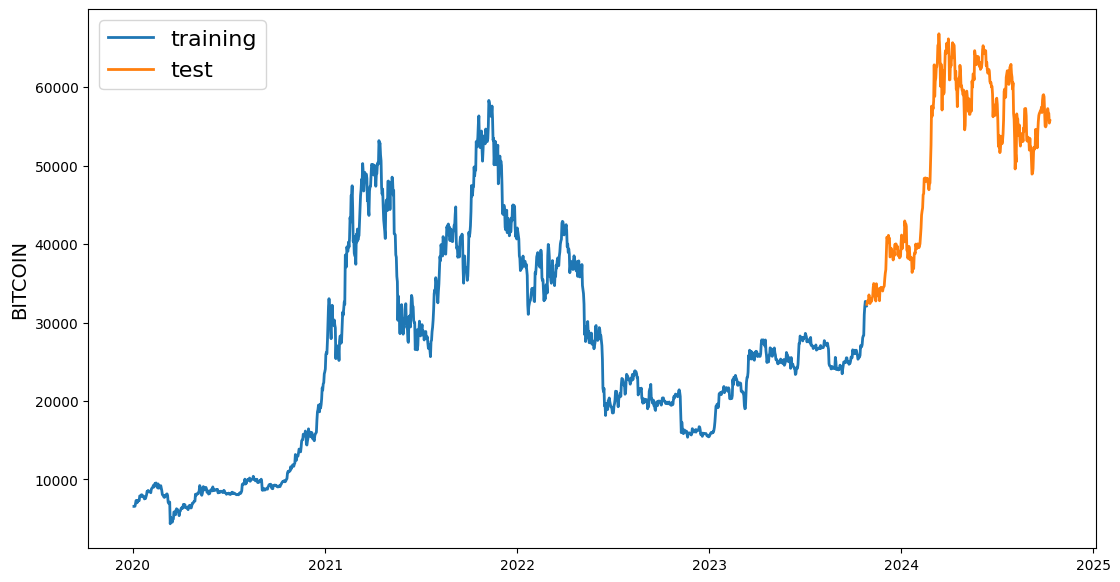

In [451]:
line_plot(train_data[aim], test_data[aim], 'training', 'test', title='')

In [452]:
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

def normalise_min_max(continuous):
    data_range = continuous.max() - continuous.min()
    if data_range == 0:
        return continuous - continuous.min()
    else:
        return (continuous - continuous.min()) / data_range

In [453]:
def extract_window_data(continuous, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [454]:
loss = Huber()

In [455]:
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.1, loss=loss, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

np.random.seed(245)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 15 # mettre 15 pour plus de précision # Je mets 10 pour éviter de passer la nuit dessus
batch_size = 32
loss
dropout = 0.05
optimizer = 'adam'
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [456]:
print("X_train contains NaN:", np.isnan(X_train).any())
print("X_train contains Inf:", np.isinf(X_train).any())
print("y_train contains NaN:", np.isnan(y_train).any())
print("y_train contains Inf:", np.isinf(y_train).any())

X_train contains NaN: False
X_train contains Inf: False
y_train contains NaN: False
y_train contains Inf: False


In [457]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)

Epoch 1/15


c:\wamp64\www\IPSSI\MIA 2\BigData\TpGroupe\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0044 - val_loss: 9.3040e-04
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 7.0973e-04
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 6.1086e-04
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 5.5253e-04
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 5.4984e-04
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 4.6841e-04
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 4.7665e-04
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 4.4774e-04
Epoch 9/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 4.3125e-04
Epoch 10/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5337e-04 - val_loss: 4.1961e-04
Epoch 11/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5072e-04 - val_loss: 3.9856e-04
Epoch 12/15
44/44 ━━━━━━━━━━━━━━

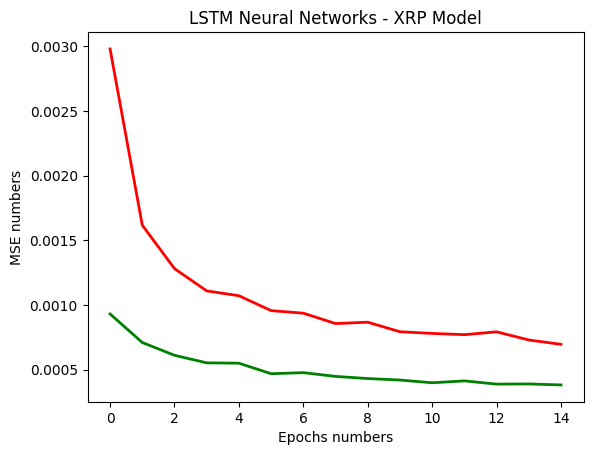

In [458]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - XRP Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [459]:
targets = test_data[aim][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


0.02014342579645862

In [460]:
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.0007637544892880015

In [461]:
r2=r2_score(y_test, preds)
r2*100

76.97396351205022

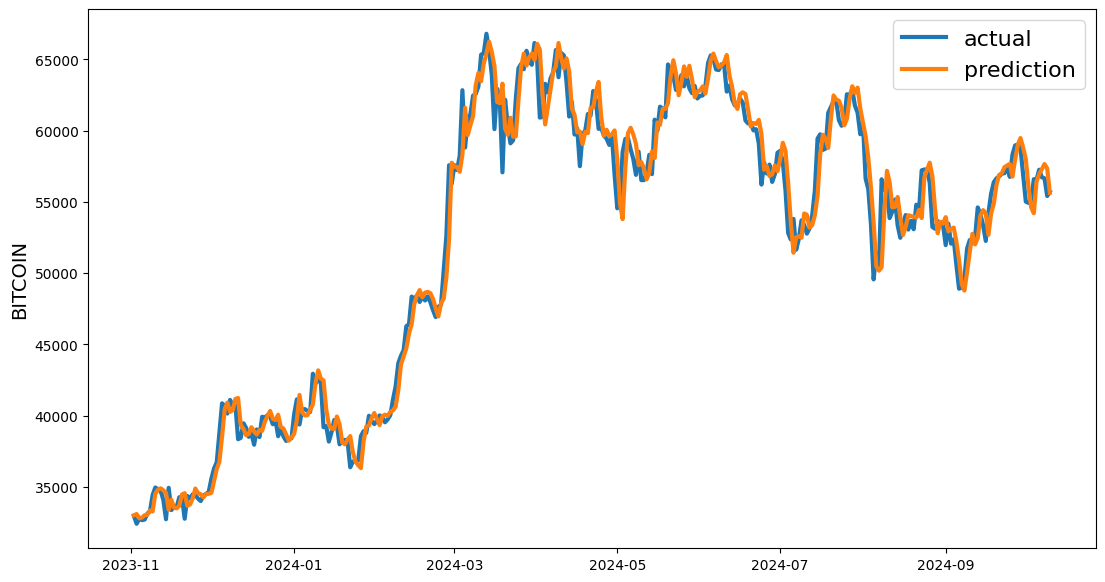

In [462]:
preds = test_data[aim].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [4]:
from tensorflow.keras.models import load_model # type: ignore
import pandas as pd
import glob

directories = ['../myhadoop/BTC-EUR_2020/*.csv', '../myhadoop/BTC-EUR_2021/*.csv', 
               '../myhadoop/BTC-EUR_2022/*.csv', '../myhadoop/BTC-EUR_2023/*.csv', 
               '../myhadoop/BTC-EUR_2024/*.csv']
dfs = [pd.concat((pd.read_csv(f) for f in glob.glob(directory)), ignore_index=True) for directory in directories]
data = pd.concat(dfs, ignore_index=True)

data['Date'] = pd.to_datetime(data['Open Time']).dt.date
data = data.loc[:,['Date','Open','High','Low','Close','Volume']]
data = data.set_index('Date')
data.index = pd.to_datetime(data.index,unit='ns')

In [5]:
def normalise_zero_base(series):
    return series / series.iloc[0] - 1

In [6]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
last_window = data[data.index >= (pd.to_datetime('today') - pd.DateOffset(months=1))]
window_len = 5

normalized_window = last_window.apply(normalise_zero_base)

input_data = normalized_window.values[-window_len:]
num_features = input_data.shape[1]
input_data = input_data.reshape((1, window_len, num_features))

model = load_model('lstm_model_custom.keras')
prediction = model.predict(input_data)

last_price = last_window['Close'].iloc[0]
predicted_price = (prediction[0][0] + 1) * last_price

print(f"La prochaine valeur prédite de 'Close' est : {predicted_price}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
La prochaine valeur prédite de 'Close' est : 55269.20720667981
